In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
df_items = pd.read_csv("final_data/orders_items.csv", index_col=0)
df_reviews = pd.read_csv("final_data/order_reviews.csv", index_col=0)
df_orders = pd.read_csv("final_data/orders.csv", index_col=0)
df_products = pd.read_csv("final_data/products.csv", index_col=0)
df_geolocation = pd.read_csv("final_data/geolocation.csv", index_col=0)
df_sellers = pd.read_csv("final_data/sellers.csv", index_col=0)
df_payments = pd.read_csv("final_data/order_payments.csv", index_col=0)
df_customers = pd.read_csv("final_data/customers.csv", index_col=0)
df_category = pd.read_csv("final_data/product_category_name_translation.csv", index_col=0)
df_rfm = pd.read_csv('rfm.csv', index_col=0)

df_orders.reset_index(inplace=True)
df_orders.dropna(inplace=True)
df_orders = df_orders[df_orders['order_status']=='delivered']
df_customers.reset_index(inplace=True)
df_items.drop(columns=['shipping_limit_date_1', 'price_2', 'freight_value_3'], inplace=True)
df_items.columns = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
df_items.dropna(inplace=True)

dataset_11 = (
    df_customers
    .merge(df_orders, on='customer_id')
    .merge(df_items, on='order_id')
    .merge(df_products, on='product_id')
    .merge(df_sellers, on='seller_id')
    .merge(df_reviews, on='order_id')
)

dataset_11 = dataset_11[
    ['customer_unique_id', 'price', 'freight_value', 'order_purchase_timestamp', 
     'order_delivered_customer_date', 'product_category_name', 'review_score', 
     'order_id', 'review_comment_message', 'customer_city', 'seller_city',
     'customer_state', 'product_photos_qty', 'product_weight_g', 
     'product_length_cm', 'product_height_cm', 'product_width_cm']]  # по итогу сырые признаки вот такие используются

dataset_11['order_purchase_timestamp'] = pd.to_datetime(dataset_11['order_purchase_timestamp'])
dataset_11['order_delivered_customer_date'] = pd.to_datetime(dataset_11['order_delivered_customer_date'])
print(dataset_11.isna().sum(), end='\n\n')
dataset_11 = dataset_11.dropna(subset=['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name'])
print(dataset_11.isna().sum())

customer_unique_id                   0
price                                0
freight_value                        0
order_purchase_timestamp             0
order_delivered_customer_date        0
product_category_name             1532
review_score                         0
order_id                             0
review_comment_message           63867
customer_city                        0
seller_city                          0
customer_state                       0
product_photos_qty                1532
product_weight_g                    18
product_length_cm                   18
product_height_cm                   18
product_width_cm                    18
dtype: int64

customer_unique_id                   0
price                                0
freight_value                        0
order_purchase_timestamp             0
order_delivered_customer_date        0
product_category_name                0
review_score                         0
order_id                             0
review_comm

In [3]:
def prepare_churn_dataset(df, predict_days=60, churn_days=120, min_orders=1):
    """
    Готовит датасет для обучения модели оттока клиентов, улучшенная версия без встроенных преобразований.
    
    df — датафрейм с заказами
    predict_days — сколько последних дней считаем "предсказуемым будущим"
    churn_days — сколько дней без заказов считаем оттоком
    min_orders — минимальное кол-во заказов, чтобы участвовать в обучении
    
    Возвращает:
        train_df — для обучения (с меткой y)
        predict_df — для прогноза (без y)
    """
    # Убедимся, что дата в нужном формате
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
    
    # Последняя дата в данных
    last_date = df["order_purchase_timestamp"].max()
    
    # Отсечки
    cutoff_predict = last_date - dt.timedelta(days=predict_days)
    cutoff_churn = last_date - dt.timedelta(days=churn_days)

    df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    df['total_price'] = df['price'] + df['freight_value']
    df['product_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
    
    # Агрегация по клиенту с дополнительными признаками
    agg = df.groupby("customer_unique_id").agg(
        latest_order=('order_purchase_timestamp', 'max'),
        mean_delivery_time=('delivery_time', 'mean'),
        n_categories=('product_category_name', 'nunique'),
        n_orders=('order_id', 'nunique'),
        n_sellers=('order_id', 'nunique'),
        avg_price=('price', 'mean'),
        avg_freight=('freight_value', 'mean'),
        LTV=('total_price', 'sum'),
        avg_review=('review_score', 'mean'),
        avg_product_volume=('product_volume', 'mean'),
        avg_product_photos_qty = ('product_photos_qty', 'mean'),
        n_comments = ('review_comment_message', 'count'),
        most_common_category=('product_category_name', lambda x: x.mode()[0]),
        most_common_customer_city=('customer_city', lambda x: x.mode()[0]),
        most_common_seller_city=('seller_city', lambda x: x.mode()[0]),
        most_common_state=('customer_state', lambda x: x.mode()[0])
    ).reset_index()
    
    # Фильтруем только клиентов с нужным кол-вом заказов
    agg = agg[agg["n_orders"] >= min_orders].copy()

    #Добавляем доп. признаки
    agg["comment_activity"] = np.round(agg["n_comments"] / agg["n_orders"], 3)

    # Назначаем группы
    agg["group"] = "predict"
    agg.loc[(agg["latest_order"] < cutoff_predict) & (agg["latest_order"] >= cutoff_churn), "group"] = "train"
    agg.loc[(agg["latest_order"] < cutoff_churn), "group"] = "churned"
    agg.drop(columns="latest_order", inplace=True)
    
    # Целевая переменная
    agg["y"] = None
    agg.loc[agg["group"] == "train", "y"] = 0
    agg.loc[agg["group"] == "churned", "y"] = 1
    
    # Отдельно train и predict
    train_df = agg[agg["group"].isin(["train", "churned"])].copy()
    predict_df = agg[agg["group"] == "predict"].copy()
    
    return train_df.set_index('customer_unique_id').drop(columns='group'), predict_df.set_index('customer_unique_id').drop(columns='group')

In [4]:
train_df, predict_df = prepare_churn_dataset(dataset_11)
train_df.head()

,mean_delivery_time,n_categories,n_orders,n_sellers,avg_price,avg_freight,LTV,avg_review,avg_product_volume,avg_product_photos_qty,n_comments,most_common_category,most_common_customer_city,most_common_seller_city,most_common_state,comment_activity,y
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f-3b9a-7992-bf8c-76cfdf3221e2,6.0,1,1,1,129.90,12.00,141.90,5.0,7616.0,1.0,1,cama_mesa_banho,cajamar,piracicaba,SP,1.0,0
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,3.0,1,1,1,18.90,8.29,27.19,4.0,5148.0,1.0,0,beleza_saude,osasco,sao paulo,SP,0.0,0
0000f46a-3911-fa3c-0805-444483337064,25.0,1,1,1,69.00,17.22,86.22,3.0,43750.0,3.0,0,papelaria,sao jose,campo limpo paulista,SC,0.0,1
0000f6cc-b074-5a6a-4b88-665a16c9f078,20.0,1,1,1,25.99,17.63,43.62,4.0,1045.0,5.0,1,telefonia,belem,sao paulo,PA,1.0,1
0004aac8-4e0d-f4da-2b14-7fca70cf8255,13.0,1,1,1,180.00,16.89,196.89,5.0,528.0,3.0,0,telefonia,sorocaba,jacarei,SP,0.0,1


In [5]:
active_customers = train_df[train_df['y']==0]
inactive_customers = train_df[train_df['y']==1]

In [6]:
print('Число активных пользователей:', len(active_customers))
print('Доля активных пользователей:', round(len(active_customers)/len(train_df), 3))
print()
print('Число неактивных пользователей:', len(inactive_customers))
print('Доля неактивных пользователей:', round(len(inactive_customers)/len(train_df), 3))

Число активных пользователей: 12376
Доля активных пользователей: 0.156

Число неактивных пользователей: 66790
Доля неактивных пользователей: 0.844


In [7]:
train_df

,mean_delivery_time,n_categories,n_orders,n_sellers,avg_price,avg_freight,LTV,avg_review,avg_product_volume,avg_product_photos_qty,n_comments,most_common_category,most_common_customer_city,most_common_seller_city,most_common_state,comment_activity,y
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f-3b9a-7992-bf8c-76cfdf3221e2,6.0,1,1,1,129.90,12.00,141.90,5.0,7616.0,1.0,1,cama_mesa_banho,cajamar,piracicaba,SP,1.0,0
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,3.0,1,1,1,18.90,8.29,27.19,4.0,5148.0,1.0,0,beleza_saude,osasco,sao paulo,SP,0.0,0
0000f46a-3911-fa3c-0805-444483337064,25.0,1,1,1,69.00,17.22,86.22,3.0,43750.0,3.0,0,papelaria,sao jose,campo limpo paulista,SC,0.0,1
0000f6cc-b074-5a6a-4b88-665a16c9f078,20.0,1,1,1,25.99,17.63,43.62,4.0,1045.0,5.0,1,telefonia,belem,sao paulo,PA,1.0,1
0004aac8-4e0d-f4da-2b14-7fca70cf8255,13.0,1,1,1,180.00,16.89,196.89,5.0,528.0,3.0,0,telefonia,sorocaba,jacarei,SP,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5-ff07-b090-8bd4-e2dbc735a684,27.0,1,1,1,785.00,248.71,2067.42,5.0,251625.0,1.0,0,beleza_saude,sanharo,sao paulo,PE,0.0,1
fffea47c-d6d3-cc0a-88bd-621562a9d061,30.0,1,1,1,64.89,19.69,84.58,4.0,32076.0,2.0,0,bebes,feira de santana,laranjal paulista,BA,0.0,1
ffff371b-4d64-5b6e-cea2-44b27531430a,14.0,1,1,1,89.90,22.56,112.46,5.0,3315.0,5.0,0,automotivo,sinop,belo horizonte,MT,0.0,1


<Axes: >

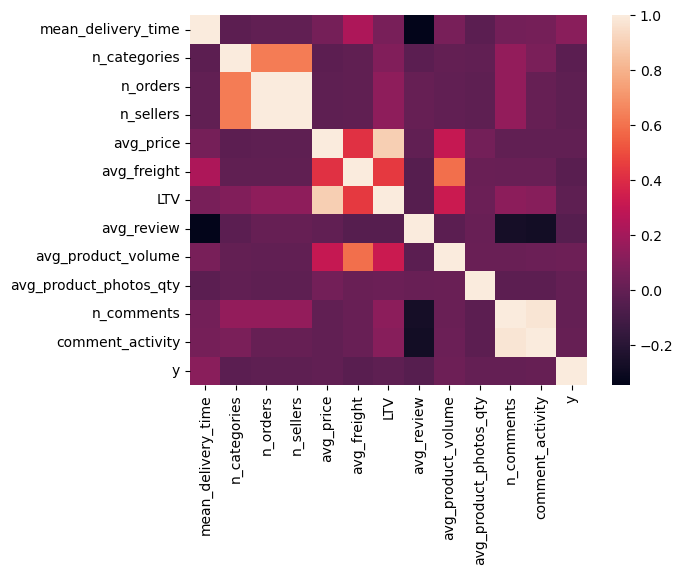

In [8]:
sns.heatmap(train_df.drop(columns=['most_common_category', 'most_common_customer_city', 'most_common_seller_city', 'most_common_state']).corr())

### Geolocation analysis

#### Customers Cities

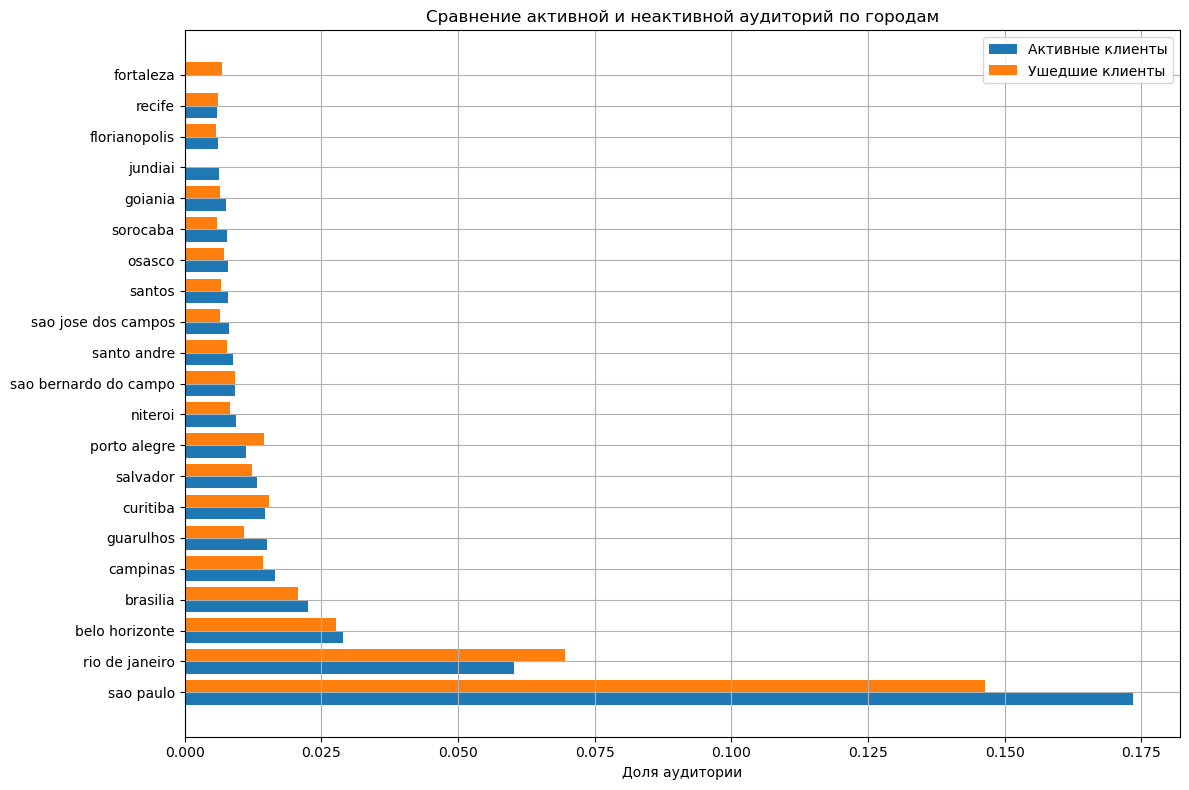

In [9]:
top_active = active_customers['most_common_customer_city'].value_counts().head(20)
top_inactive = inactive_customers['most_common_customer_city'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_customers[active_customers['most_common_customer_city'].isin(common_cities)]['most_common_customer_city'].value_counts().head(20) / len(active_customers))
inactive_normalized = (inactive_customers[inactive_customers['most_common_customer_city'].isin(common_cities)]['most_common_customer_city'].value_counts().head(20) / len(inactive_customers))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Сравнение активной и неактивной аудиторий по городам')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

#### Sellers Cities

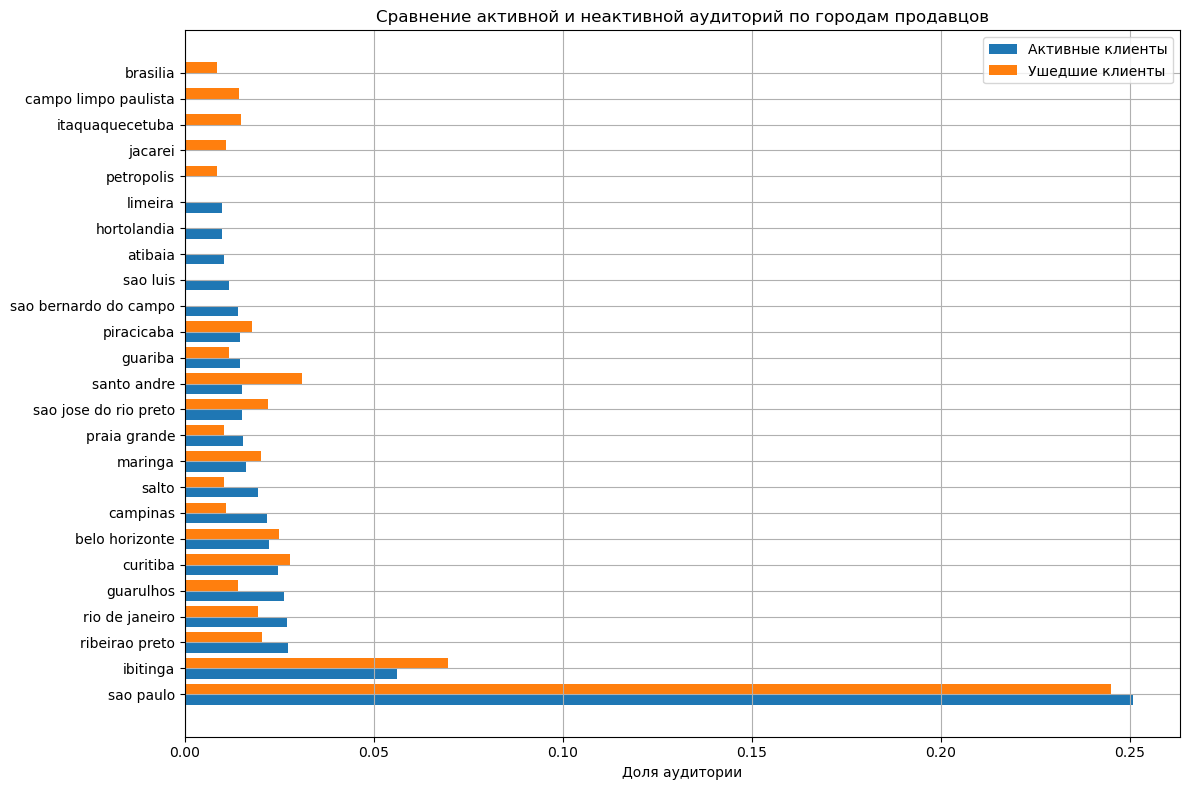

In [10]:
top_active = active_customers['most_common_seller_city'].value_counts().head(20)
top_inactive = inactive_customers['most_common_seller_city'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_customers[active_customers['most_common_seller_city'].isin(common_cities)]['most_common_seller_city'].value_counts().head(20) / len(active_customers))
inactive_normalized = (inactive_customers[inactive_customers['most_common_seller_city'].isin(common_cities)]['most_common_seller_city'].value_counts().head(20) / len(inactive_customers))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Сравнение активной и неактивной аудиторий по городам продавцов')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

#### States

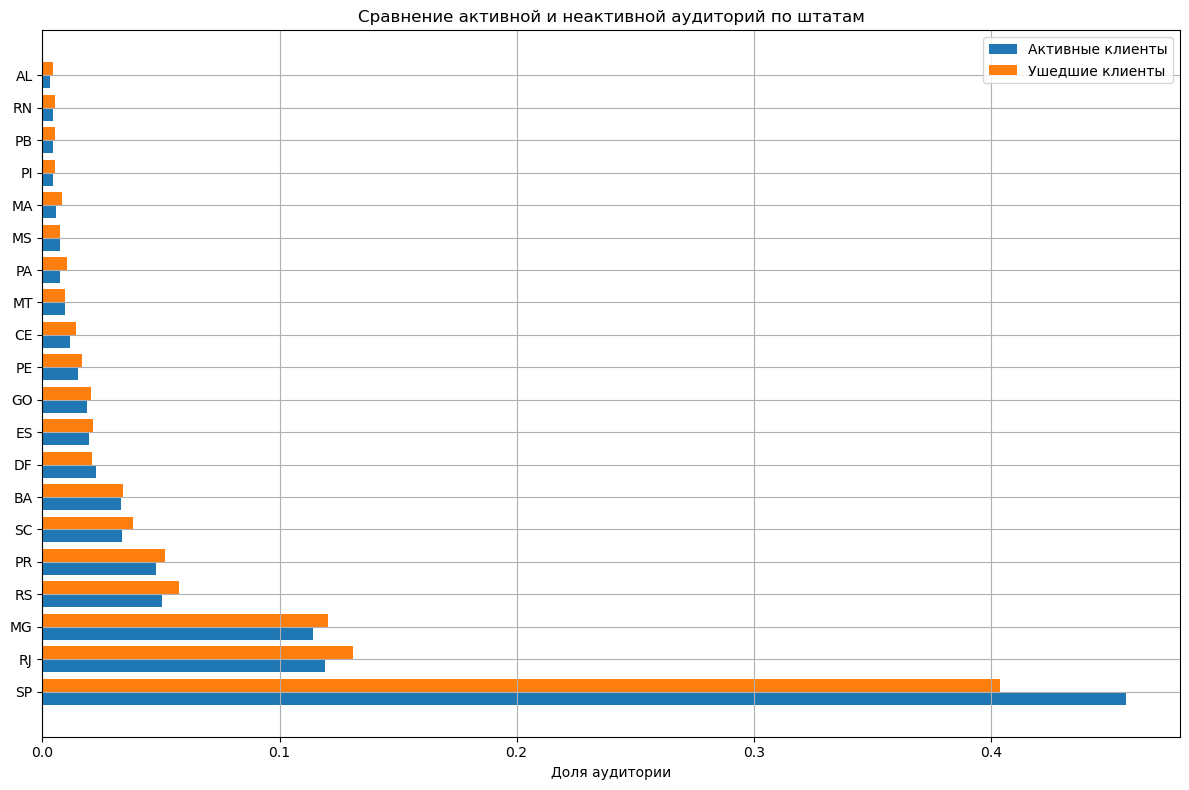

In [11]:
top_active = active_customers['most_common_state'].value_counts().head(20)
top_inactive = inactive_customers['most_common_state'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_customers[active_customers['most_common_state'].isin(common_cities)]['most_common_state'].value_counts().head(20) / len(active_customers))
inactive_normalized = (inactive_customers[inactive_customers['most_common_state'].isin(common_cities)]['most_common_state'].value_counts().head(20) / len(inactive_customers))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Сравнение активной и неактивной аудиторий по штатам')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

### Categories_analysis

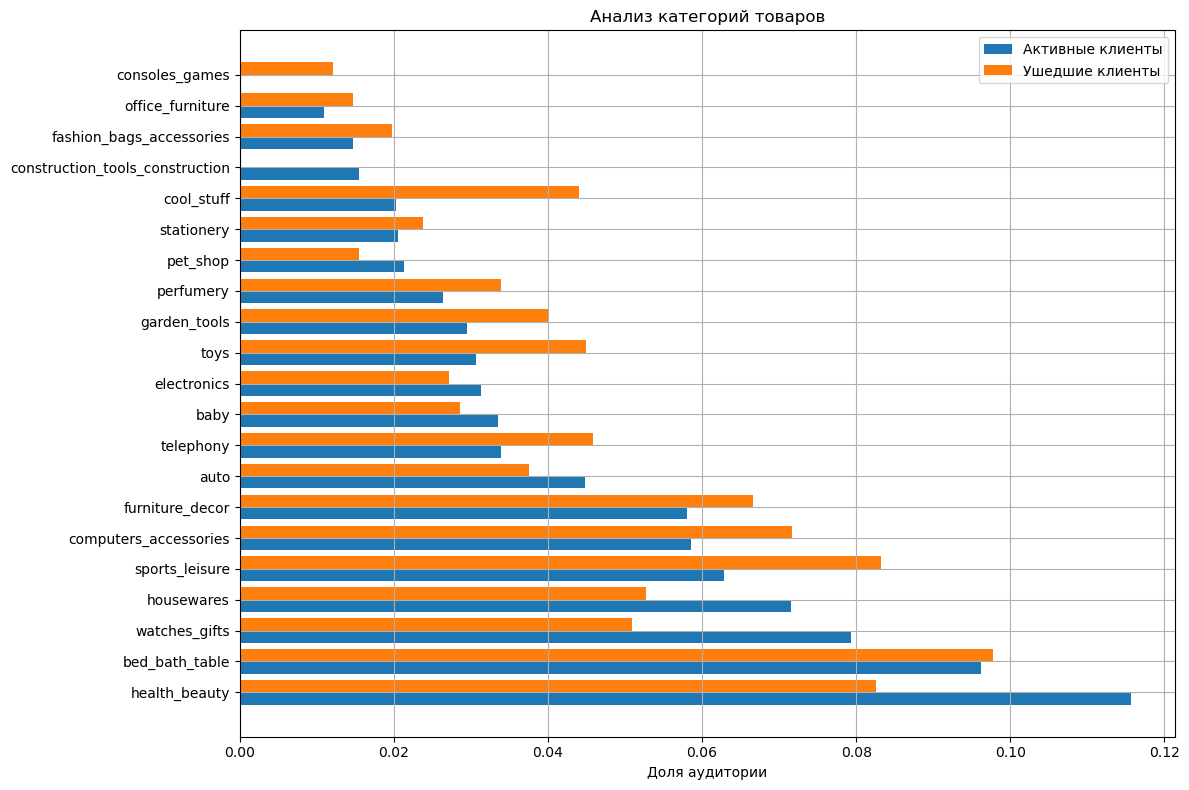

In [12]:
top_active = active_customers['most_common_category'].value_counts().head(20)
top_inactive = inactive_customers['most_common_category'].value_counts().head(20)
common_cities = set(top_active.index).union(set(top_inactive.index))

active_normalized = (active_customers[active_customers['most_common_category'].isin(common_cities)]['most_common_category'].value_counts().head(20) / len(active_customers))
inactive_normalized = (inactive_customers[inactive_customers['most_common_category'].isin(common_cities)]['most_common_category'].value_counts().head(20) / len(inactive_customers))

combined = active_normalized.to_frame('active').join(inactive_normalized.to_frame('inactive'), how='outer').fillna(0)
combined = combined.sort_values('active', ascending=False)  # Sort for better visualization
combined_english = (
    combined
    .merge(df_category, left_index=True, right_on='product_category_name', how='left')
    .reset_index()
    .set_index('product_category_name_english'))

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(combined))

bars1 = ax.barh(index, combined['active'], bar_width, label='Активные клиенты')
bars2 = ax.barh(index + bar_width, combined['inactive'], bar_width, label='Ушедшие клиенты')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(combined_english.index)
ax.set_xlabel('Доля аудитории')
ax.set_title('Анализ категорий товаров')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

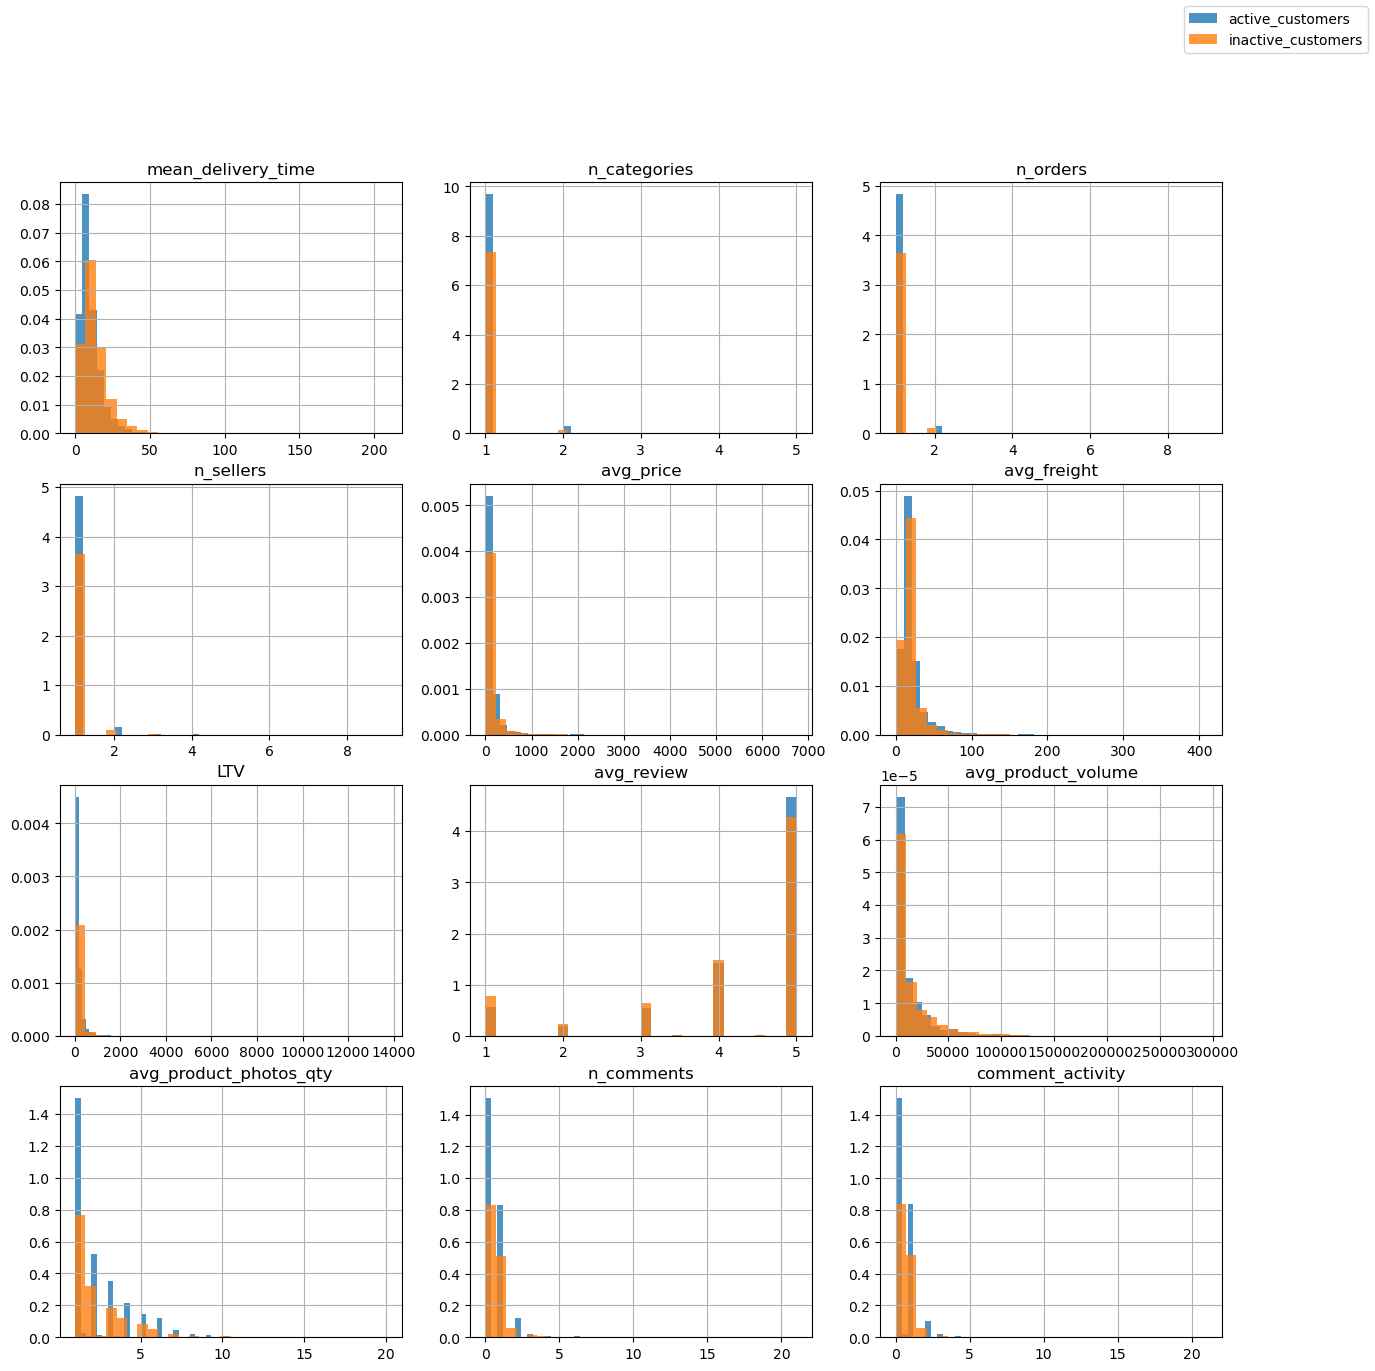

In [13]:
fig, ax = plt.subplots(4,3, figsize=(15, 15))
cols = active_customers.drop(columns=['most_common_category', 'most_common_customer_city', 
                                      'most_common_seller_city', 'most_common_state']).columns
k = 0

for i in range(4):
    for j in range(3):
        ax[i, j].hist(active_customers[cols[k]],bins=30, density=True, alpha=0.8)
        ax[i, j].hist(inactive_customers[cols[k]],bins=30, density=True, alpha=0.8)
        ax[i, j].set_title(cols[k])
        ax[i, j].grid()
        k += 1
fig.legend(['active_customers', 'inactive_customers'])

### Статистика по максимальным промежуткам между двумя соседними заказами

Распределение максимальных перерывов между заказами (в днях)


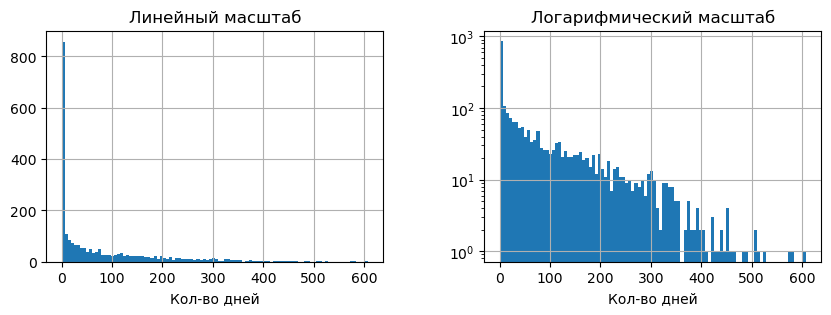

In [14]:
df_orders_to_customers = df_orders.merge(df_customers, on='customer_id', how='inner')
df_orders_to_customers['order_purchase_timestamp'] = pd.to_datetime(df_orders_to_customers['order_purchase_timestamp'])

sorted_orders = (
    df_orders_to_customers.loc[
        df_orders_to_customers['customer_unique_id'].isin(train_df[train_df['n_orders']>1].index),
        ['order_id', 'customer_unique_id', 'order_purchase_timestamp']
    ]
    .sort_values(['customer_unique_id', 'order_purchase_timestamp'])
)

days_between_orders = (
    sorted_orders
    .assign(
        days_since_previous=lambda x: x.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days
    )
    .dropna(subset=['days_since_previous'])
    [['customer_unique_id', 'days_since_previous']]
    .reset_index(drop=True)
)

max_days_since_previous = days_between_orders.groupby('customer_unique_id')['days_since_previous'].max().to_frame(name='max_period')
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
max_days_since_previous.hist(bins=100, ax=ax[0])
ax[0].set_title('Линейный масштаб')
ax[0].set_xlabel('Кол-во дней')
max_days_since_previous.hist(bins=100, log=True, ax=ax[1])
ax[1].set_title('Логарифмический масштаб')
ax[1].set_xlabel('Кол-во дней')
print('Распределение максимальных перерывов между заказами (в днях)')

### Связь между числом заказов и кол-вом пользователей

Распределение клиентов по кол-ву и заказов кол-ву продавцов:


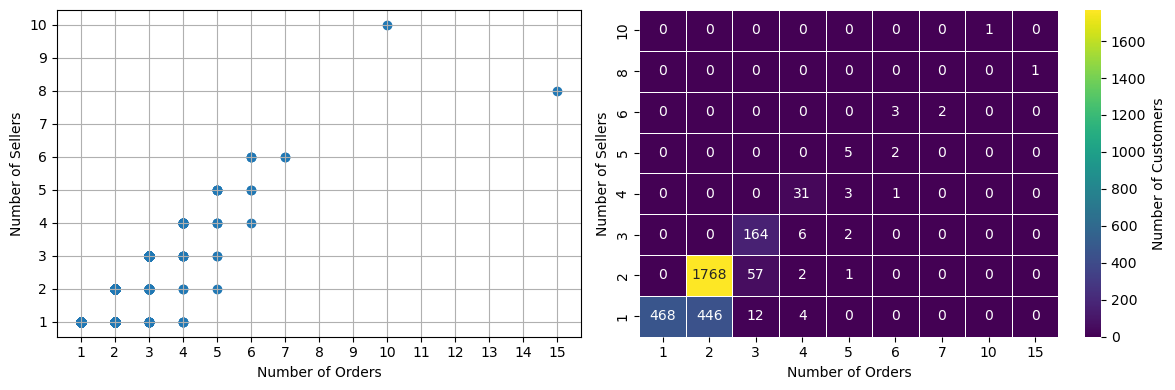

In [15]:
n_orders_by_customers = df_customers.groupby('customer_unique_id').agg(n_orders=('customer_id', 'count'))
customers_to_sellers = (
    n_orders_by_customers[n_orders_by_customers['n_orders']>1]
    .merge(df_customers[['customer_id', 'customer_unique_id']], on='customer_unique_id', how='inner')
    .merge(df_orders, on='customer_id', how='inner')
    .merge(df_items, on='order_id', how='inner')
    .merge(df_sellers, on='seller_id', how='inner')
)

customers_to_sellers = customers_to_sellers[['seller_id', 'customer_unique_id', 'order_purchase_timestamp']]
customers_to_sellers['order_purchase_timestamp'] = pd.to_datetime(customers_to_sellers['order_purchase_timestamp'])
customers_to_sellers['order_purchase_timestamp'] = customers_to_sellers['order_purchase_timestamp'].dt.date
customers_to_sellers = customers_to_sellers.sort_values(by=['seller_id', 'customer_unique_id', 'order_purchase_timestamp'])
customers_to_sellers = customers_to_sellers.drop_duplicates()

n_sellers_orders_by_customers = (customers_to_sellers
                                 .groupby('customer_unique_id')
                                 .agg(n_sellers=('seller_id', 'nunique'), 
                                      n_orders=('order_purchase_timestamp', 'count')))

cross_tab = pd.crosstab(
    n_sellers_orders_by_customers['n_sellers'], 
    n_sellers_orders_by_customers['n_orders']
).iloc[::-1]

print('Распределение клиентов по кол-ву и заказов кол-ву продавцов:')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(n_sellers_orders_by_customers['n_orders'], n_sellers_orders_by_customers['n_sellers'])
ax[0].grid()
ax[0].set_xticks(np.arange(1, 16))
ax[0].set_yticks(np.arange(1, 11))
ax[0].set_xlabel('Number of Orders')
ax[0].set_ylabel('Number of Sellers')

sns.heatmap(cross_tab, 
        annot=True, 
        fmt='d', 
        cmap='viridis', 
        linewidths=.5,
        cbar_kws={'label': 'Number of Customers'},
        ax=ax[1])

ax[1].set_xlabel('Number of Orders')
ax[1].set_ylabel('Number of Sellers')
plt.tight_layout()
plt.show()